In this notebook we investigate the non-detection comet C/2009 P1 by Boissier et al. 2013 when using IRAM at Plateau de Bure (10.1051/0004-6361/201321372).
We compare the positions reported in Boissier et al. 2013 to astrometry from the MPC observations database and the current JPL Horizons solution (both retrieved 29/12/2023).

In [1]:
%matplotlib notebook

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import os
import healpy as hp

from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u
from astroquery.jplhorizons import Horizons
from astropy.coordinates import Angle


In [4]:
# file format for MPC observations

# COMETS
#    Columns     Format   Use
#     1 -  4       I4     Periodic comet number
#     5            A1     Letter indicating type of orbit
#     6 - 12       A7     Provisional or temporary designation
#    13            X      Not used, must be blank
# MINOR PLANETS, COMETS AND NATURAL SATELLITES
#    Columns     Format   Use
#    14            A1     Note 1
#    15            A1     Note 2
#    16 - 32              Date of observation
#    33 - 44              Observed RA (J2000.0)
#    45 - 56              Observed Decl. (J2000.0)
#    57 - 65       9X     Must be blank
#    66 - 71    F5.2,A1   Observed magnitude and band
#                            (or nuclear/total flag for comets)
#    72 - 77       X      Must be blank
#    78 - 80       A3     Observatory code

cols = [(0,4),#      I4     Periodic comet number
    (4,5),#   A1     Letter indicating type of orbit
    (5,13),#   A7     Provisional or temporary designation
   (13,14),#    A1     Note 1
   (14,15),#    A1     Note 2
   (15,32),#              Date of observation
   (32,44),#              Observed RA (J2000.0)
   (44,56),#              Observed Decl. (J2000.0)
   (65,71),#    F5.2,A1   Observed magnitude and band
   (77,80)#       A3     Observatory code
       ]

labels = ["number", 
          "type", 
          "desig", 
          "Note 1",
          "Note 2",
            "date",
            "RA",
            "Dec",
            "mag",
            "obs"]

In [5]:
# retrieve the mpc observations from: https://minorplanetcenter.net/db_search
# and save as a txt file
# load this file into the notebook:
fname = "mpc_obs_C2009_P1.txt"
df_mpc = pd.read_fwf(fname, colspecs = cols, names = labels, delimiter="\n\t")

In [6]:
df_mpc

,number,type,desig,Note 1,Note 2,date,RA,Dec,mag,obs
0,,C,K09P010,,C,2008 09 27.55978,00 19 16.57,-49 46 52.2,18.6 T,E12
1,,C,K09P010,,C,2008 09 27.56892,00 19 16.10,-49 46 53.0,19.2 T,E12
2,,C,K09P010,,C,2008 09 27.57795,00 19 15.70,-49 46 52.7,19.0 T,E12
3,,C,K09P010,,C,2008 09 27.58700,00 19 15.31,-49 46 53.0,20.1 T,E12
4,,C,K09P010,,C,2009 08 13.76794,00 16 01.27,-44 33 23.1,17.5 T,E12
...,...,...,...,...,...,...,...,...,...,...
9123,,C,K09P010,1,C,2013 11 01.71753,09 00 43.99,-17 56 14.6,18.9 T,Q62
9124,,C,K09P010,K,C,2013 11 29.24760,08 54 37.82,-20 34 46.5,20.3 N,W96
9125,,C,K09P010,K,C,2013 11 29.29486,08 54 36.81,-20 34 58.0,20.5 N,W96
9126,,C,K09P010,K,C,2014 02 26.11204,08 02 55.71,-22 02 01.6,21.0 N,W96


In [7]:
# convert ra and dec to degrees
c_mpc = SkyCoord(df_mpc["RA"],df_mpc["Dec"],unit=(u.hourangle,u.deg))
df_mpc["ra(deg)"] = c_mpc.ra.degree
df_mpc["dec(deg)"] = c_mpc.dec.degree

In [8]:
c_mpc

<SkyCoord (ICRS): (ra, dec) in deg
    [(  4.81904167, -49.78116667), (  4.81708333, -49.78138889),
     (  4.81541667, -49.78130556), ..., (133.653375  , -20.58277778),
     (120.732125  , -22.03377778), (120.72945833, -22.03225   )]>

In [9]:
# extract the calendar date
df_mpc['calendar date'] = df_mpc['date'].str.split(".").str[0]

# get the day fraction to add to the calendar date mjd
d = np.array(df_mpc["date"].str.split(" ").str[2].astype(float))
df_mpc["date_frac(mjd)"] = d - d.astype(int)

In [ ]:
# # The make_decimal function only works for strings of numbers with fixed number of decimal points!

# def make_decimal(x):
#     """
#     function to reduce a value (or array) to a decimal <1
#     Will continue until operating on all array values until all are decimals <1
#     """
#     while (x>1.0).any():
#         x = x/10
#     return x

# # the make decimal_value function does not work for decimals <0.1
# # e.g 21.09 -> 09 -> 0.9 (not 0.09)
# def make_decimal_value(x):
#     """
#     function to reduce a value (or array) to a decimal <1
#     """
#     while (x>1.0):
#         x = x/10
#     return x

In [10]:
# convert dates to mjd
times=[datetime.strptime(d,"%Y %m %d") for d in np.array(df_mpc["calendar date"])]
df_mpc["date(mjd)"] = Time(times).mjd + df_mpc["date_frac(mjd)"]

In [11]:
df_mpc

,number,type,desig,Note 1,Note 2,date,RA,Dec,mag,obs,ra(deg),dec(deg),calendar date,date_frac(mjd),date(mjd)
0,,C,K09P010,,C,2008 09 27.55978,00 19 16.57,-49 46 52.2,18.6 T,E12,4.819042,-49.781167,2008 09 27,0.55978,54736.55978
1,,C,K09P010,,C,2008 09 27.56892,00 19 16.10,-49 46 53.0,19.2 T,E12,4.817083,-49.781389,2008 09 27,0.56892,54736.56892
2,,C,K09P010,,C,2008 09 27.57795,00 19 15.70,-49 46 52.7,19.0 T,E12,4.815417,-49.781306,2008 09 27,0.57795,54736.57795
3,,C,K09P010,,C,2008 09 27.58700,00 19 15.31,-49 46 53.0,20.1 T,E12,4.813792,-49.781389,2008 09 27,0.58700,54736.58700
4,,C,K09P010,,C,2009 08 13.76794,00 16 01.27,-44 33 23.1,17.5 T,E12,4.005292,-44.556417,2009 08 13,0.76794,55056.76794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9123,,C,K09P010,1,C,2013 11 01.71753,09 00 43.99,-17 56 14.6,18.9 T,Q62,135.183292,-17.937389,2013 11 01,0.71753,56597.71753
9124,,C,K09P010,K,C,2013 11 29.24760,08 54 37.82,-20 34 46.5,20.3 N,W96,133.657583,-20.579583,2013 11 29,0.24760,56625.24760
9125,,C,K09P010,K,C,2013 11 29.29486,08 54 36.81,-20 34 58.0,20.5 N,W96,133.653375,-20.582778,2013 11 29,0.29486,56625.29486
9126,,C,K09P010,K,C,2014 02 26.11204,08 02 55.71,-22 02 01.6,21.0 N,W96,120.732125,-22.033778,2014 02 26,0.11204,56714.11204


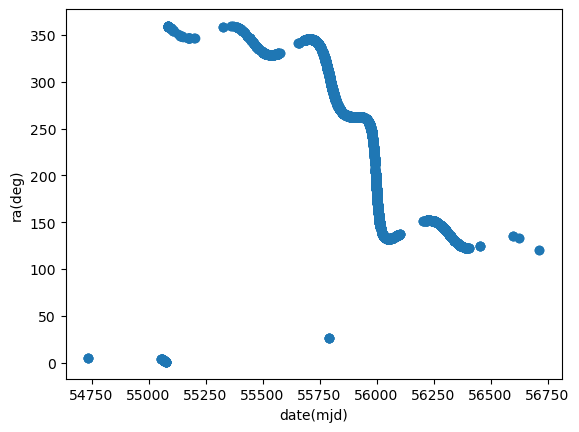

In [12]:
# plot of ra against time
x_plot = "date(mjd)"
y_plot = "ra(deg)"
df_plot = df_mpc

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

ax1.scatter(df_plot[x_plot],df_plot[y_plot])

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.show()

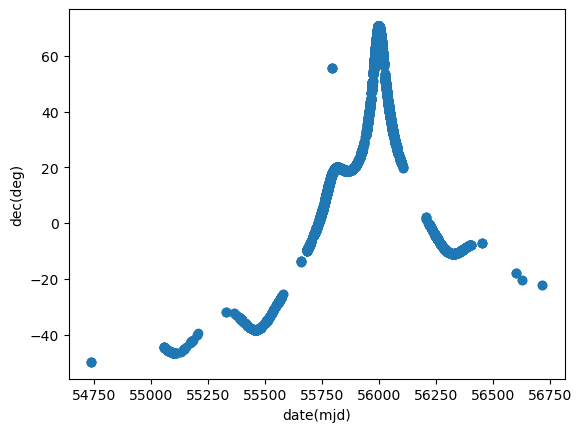

In [13]:
# plot of dec against time
x_plot = "date(mjd)"
y_plot = "dec(deg)"
df_plot = df_mpc

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

ax1.scatter(df_plot[x_plot],df_plot[y_plot])

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.show()

In [14]:
# outliers?
mask = (df_mpc["dec(deg)"]>50) & (df_mpc["date(mjd)"]<55800)
df_mpc[mask]

,number,type,desig,Note 1,Note 2,date,RA,Dec,mag,obs,ra(deg),dec(deg),calendar date,date_frac(mjd),date(mjd)
2310,,C,K09P010,,v,2011 08 18.89752,1 046.42136,+55.49007,,247,26.60534,55.49007,2011 08 18,0.89752,55791.89752
2312,,C,K09P010,,v,2011 08 18.90006,1 046.42136,+55.49007,,247,26.60534,55.49007,2011 08 18,0.90006,55791.90006
2314,,C,K09P010,,v,2011 08 18.90044,1 046.42136,+55.49007,,247,26.60534,55.49007,2011 08 18,0.90044,55791.90044
2316,,C,K09P010,,v,2011 08 18.90082,1 046.42136,+55.49007,,247,26.60534,55.49007,2011 08 18,0.90082,55791.90082
2318,,C,K09P010,,v,2011 08 18.90120,1 046.42136,+55.49007,,247,26.60534,55.49007,2011 08 18,0.90120,55791.90120


In [15]:
# "roving observer" observations?
df_mpc[df_mpc["Note 2"]=="v"]

,number,type,desig,Note 1,Note 2,date,RA,Dec,mag,obs,ra(deg),dec(deg),calendar date,date_frac(mjd),date(mjd)
2310,,C,K09P010,,v,2011 08 18.89752,1 046.42136,+55.49007,,247,26.60534,55.49007,2011 08 18,0.89752,55791.89752
2312,,C,K09P010,,v,2011 08 18.90006,1 046.42136,+55.49007,,247,26.60534,55.49007,2011 08 18,0.90006,55791.90006
2314,,C,K09P010,,v,2011 08 18.90044,1 046.42136,+55.49007,,247,26.60534,55.49007,2011 08 18,0.90044,55791.90044
2316,,C,K09P010,,v,2011 08 18.90082,1 046.42136,+55.49007,,247,26.60534,55.49007,2011 08 18,0.90082,55791.90082
2318,,C,K09P010,,v,2011 08 18.90120,1 046.42136,+55.49007,,247,26.60534,55.49007,2011 08 18,0.90120,55791.90120


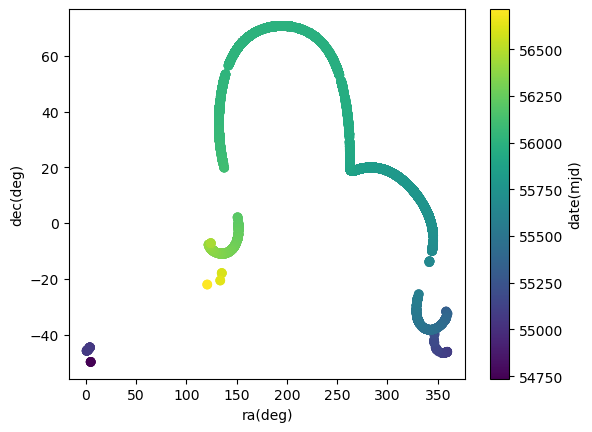

In [16]:
# plot dec vs ra (coloured by time of observation), excluding roving observations
x_plot = "ra(deg)"
y_plot = "dec(deg)"
c_plot = "date(mjd)"

mask = df_mpc["Note 2"]!="v"
df_plot = df_mpc[mask]

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

s1 = ax1.scatter(df_plot[x_plot],df_plot[y_plot], c = df_plot[c_plot])
cbar1 = plt.colorbar(s1)

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
cbar1.set_label(c_plot)

plt.show()

In [17]:
# query JPL horizons for the ephemerides of C/2009 P1 at the IRAM reference time

# IRAM location https://iram-institute.org/science-portal/noema/
Lon = Angle("05:54:28.5", unit = u.hourangle).degree
Lat = Angle("44:38:02.0", unit = u.degree).degree
Alt = 2.550 # km
loc = {"lon":Lon,"lat":Lat,"elevation":Alt}

# ephem settings
times = {'start':'2012-03-01 12:00', 'stop':'2012-03-07 12:00', # dates to query
                       'step':'10min'}


In [18]:
# query ephemerides from Horizons
object_id = "C/2009 P1"
fname_jpl = "jpl_eph_{}.csv".format("_".join("".join(object_id.split("/")).split(" ")))

if os.path.isfile(fname_jpl):
    print("load {}".format(fname_jpl))
    df_jpl = pd.read_csv(fname_jpl, index_col = 0)
else:
    print("{} query Horizons".format(object_id))
    obj = Horizons(id=object_id, location = loc, epochs = times)
    eph = obj.ephemerides()
    df_jpl = eph.to_pandas()
    print("save {}".format(fname_jpl))
    df_jpl.to_csv(fname_jpl)

load jpl_eph_C2009_P1.csv


In [19]:
# convert date to mjd
df_jpl["date(mjd)"] = Time(df_jpl["datetime_jd"],format="jd").mjd

In [20]:
df_jpl

,targetname,datetime_str,datetime_jd,M1,solar_presence,k1,flags,RA,DEC,RA_app,...,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat,date(mjd)
0,Garradd (C/2009 P1),2012-Mar-01 12:00,2.455988e+06,8.8,*,4.5,m,229.61790,66.36976,229.66011,...,0.000012,0.38,1.40,0.001100,44.6440,-10.756474,31.7378,161.5445,58.2876,55987.500000
1,Garradd (C/2009 P1),2012-Mar-01 12:10,2.455988e+06,8.8,C,4.5,m,229.59991,66.37514,229.64214,...,0.000012,0.38,1.40,0.001100,44.6477,-10.588153,31.7360,161.5358,58.2833,55987.506944
2,Garradd (C/2009 P1),2012-Mar-01 12:20,2.455988e+06,8.8,C,4.5,m,229.58192,66.38053,229.62415,...,0.000012,0.38,1.40,0.001099,44.6513,-10.419831,31.7343,161.5271,58.2791,55987.513889
3,Garradd (C/2009 P1),2012-Mar-01 12:30,2.455988e+06,8.8,N,4.5,m,229.56391,66.38591,229.60615,...,0.000012,0.38,1.40,0.001099,44.6550,-10.251508,31.7326,161.5184,58.2749,55987.520833
4,Garradd (C/2009 P1),2012-Mar-01 12:40,2.455988e+06,8.8,N,4.5,m,229.54589,66.39130,229.58815,...,0.000012,0.38,1.40,0.001099,44.6587,-10.083185,31.7308,161.5097,58.2706,55987.527778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,Garradd (C/2009 P1),2012-Mar-07 11:20,2.455994e+06,8.8,*,4.5,m,210.49819,69.93329,210.57082,...,0.000012,0.40,1.46,0.001080,47.7305,-9.758090,30.2705,154.8186,54.2991,55993.472222
861,Garradd (C/2009 P1),2012-Mar-07 11:30,2.455994e+06,8.8,*,4.5,m,210.47230,69.93594,210.54500,...,0.000012,0.40,1.46,0.001080,47.7340,-9.589246,30.2690,154.8116,54.2942,55993.479167
862,Garradd (C/2009 P1),2012-Mar-07 11:40,2.455994e+06,8.8,*,4.5,m,210.44641,69.93858,210.51918,...,0.000012,0.40,1.46,0.001080,47.7375,-9.420401,30.2675,154.8047,54.2892,55993.486111
863,Garradd (C/2009 P1),2012-Mar-07 11:50,2.455994e+06,8.8,*,4.5,m,210.42050,69.94122,210.49334,...,0.000012,0.40,1.46,0.001080,47.7410,-9.251556,30.2660,154.7978,54.2843,55993.493056


In [21]:
# IRAM detected peak location (Boissier et al. 2013 table 1)
ra = "14:46:22.870" 
dec = "+68:16:22.38"
# reference time
t = "2012-03-04 07:00"

iram_field = SkyCoord("{} {}".format(ra,dec),unit = (u.hourangle,u.deg))
iram_epoch = Time(t, format='iso')
iram_fov = 12.0 # iram field of view radius (arcsec) from Boissier et al. 2013 fig. 1

In [22]:
# find the nearest jpl ephem to the iram reference time
i_jpl = np.argmin(np.abs(df_jpl["date(mjd)"] - iram_epoch.mjd))

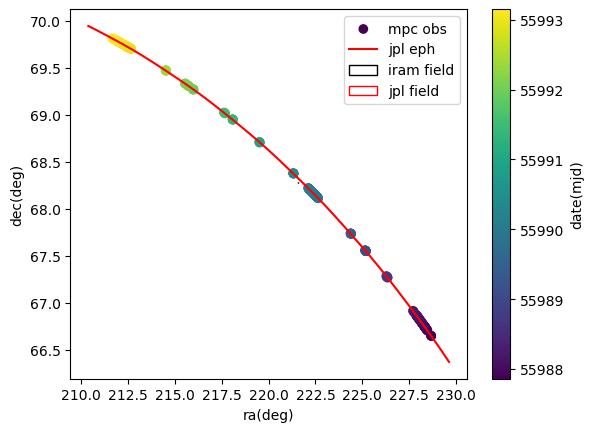

In [23]:
# plot of dec vs ra for observations near 4th March 2012

x_plot = "ra(deg)"
y_plot = "dec(deg)"
c_plot = "date(mjd)"
mask = ((df_mpc["Note 2"]!="v") & 
        (df_mpc["date(mjd)"]>=np.amin(df_jpl["date(mjd)"])) &
        (df_mpc["date(mjd)"]<np.amax(df_jpl["date(mjd)"])))
df_plot = df_mpc[mask]

x_plot2 = "RA"
y_plot2 = "DEC"
df_plot2 = df_jpl

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

# plot the MPC observations
s1 = ax1.scatter(df_plot[x_plot],df_plot[y_plot], c = df_plot[c_plot],
                label = "mpc obs")
cbar1 = plt.colorbar(s1)

# plot the JPL ephemerides
ax1.plot(df_plot2[x_plot2],df_plot2[y_plot2], c = "r", label = "jpl eph")

# plot the IRAM field at the reference position
circle1 = plt.Circle((iram_field.ra.degree, iram_field.dec.degree), iram_fov/60.0/60.0, 
                     edgecolor='k', facecolor = "none", label = "iram field")
ax1.add_patch(circle1)

# plot the extent of the IRAM field at the JPL position for that reference time
circle2 = plt.Circle((df_jpl.iloc[i_jpl][x_plot2],df_jpl.iloc[i_jpl][y_plot2]), iram_fov/60.0/60.0, 
                     edgecolor='r', facecolor = "none", label = "jpl field")
ax1.add_patch(circle2)

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
cbar1.set_label(c_plot)

# ax1.set_aspect("equal")
ax1.legend()

plt.show()

IRAM - JPL position = 3.5465972828738637 arcmin


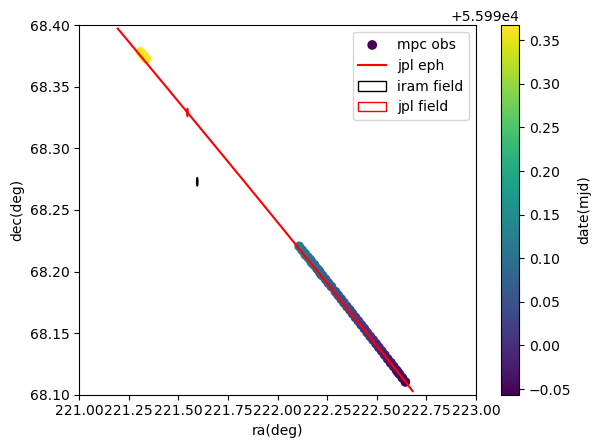

In [24]:
# zoomed in ra - dec plot

# define plot limits
ra_min = 221.
ra_max = 223
dec_min = 68.1
dec_max = 68.4

x_plot = "ra(deg)"
y_plot = "dec(deg)"
c_plot = "date(mjd)"
mask = ((df_mpc["ra(deg)"]>=ra_min) &
        (df_mpc["ra(deg)"]<ra_max) &
        (df_mpc["dec(deg)"]>=dec_min) &
        (df_mpc["dec(deg)"]<dec_max))
df_plot = df_mpc[mask]

x_plot2 = "RA"
y_plot2 = "DEC"
df_plot2 = df_jpl
mask2 = ((df_jpl[x_plot2]>=ra_min) &
        (df_jpl[x_plot2]<ra_max) &
        (df_jpl[y_plot2]>=dec_min) &
        (df_jpl[y_plot2]<dec_max))
df_plot2 = df_jpl[mask2]

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

s1 = ax1.scatter(df_plot[x_plot],df_plot[y_plot], c = df_plot[c_plot],
                label = "mpc obs")
cbar1 = plt.colorbar(s1)

ax1.plot(df_plot2[x_plot2],df_plot2[y_plot2], c = "r", label = "jpl eph")

circle1 = plt.Circle((iram_field.ra.degree, iram_field.dec.degree), iram_fov/60.0/60.0, 
                     edgecolor='k', facecolor = "none", label = "iram field")
ax1.add_patch(circle1)

circle2 = plt.Circle((df_jpl.iloc[i_jpl][x_plot2],df_jpl.iloc[i_jpl][y_plot2]), iram_fov/60.0/60.0, 
                     edgecolor='r', facecolor = "none", label = "jpl field")
ax1.add_patch(circle2)

# find the separation between the IRAM position and the JPL position
jpl_field = SkyCoord(df_jpl.iloc[i_jpl][x_plot2],df_jpl.iloc[i_jpl][y_plot2],unit = u.deg)
print("IRAM - JPL position = {} arcmin".format(iram_field.separation(jpl_field).arcmin))

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
cbar1.set_label(c_plot)

# ax1.set_aspect("equal")
ax1.legend()

ax1.set_xlim(ra_min,ra_max)
ax1.set_ylim(dec_min,dec_max)

f = "C2009_P1_iram_jpl_mpc_eph.pdf"
plt.savefig(f, facecolor="w", transparent=True, bbox_inches="tight")

plt.show()

Figure showing the astrometry of C/2009 P1 around March 2012, retrieved from the MPC observations database (markers coloured by time of observation). The most recent JPL ephemerides for the comet are shown as the red line. The IRAM field of view at the position of the detected source and reference time of 07:00 04/03/2012 (radius 12 arcsec) is shown as a black circle (Boissier et al. 2013). The field of view from the JPL ephermerides at this time is shown as a red circle.